In [87]:
### Setup
%matplotlib inline
# %load_ext pretty_jupyter

# should enable plotting without explicit call .show()

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# classes for special types
from pandas.api.types import CategoricalDtype

# Apply the default theme
sns.set_theme()

## Introduction
In this report, we'll try to predict how many times will the players score next season. The prediction will be based on various player's data, such as average ice-time, age.

## Dataset overview

The provided dataset consists of 2 csv files:

### `nhl-teams.csv`: 
This file contains names of NHL teams together with their short name.
There are 35 rows (1 row = 1 team) and only 2 columns. The structure is as follows:


In [88]:
# Reading and inspecting data
df = pd.read_csv("data/nhl-teams.csv")
df.head(10)

,team,team_full
0,ANA,Anaheim Ducks
1,ARI,Arizona Coyottes
2,ATL,Atlanta Thrashers
3,BOS,Boston Bruins
4,BUF,Buffalo Sabres
5,CAR,Carolina Hurricanes
6,CBJ,Columbus Blue Jackets
7,CGY,Calgary Flames
8,CHI,Chicago Blackhawks
9,COL,Colorado Avalanche


### `nhl-player-data.csv` 
This file contains various data about NHL players (goals, points per season, average time on ice, age, etc.) for seasons 2004-2018.
Each row contains data for the given player per season, i.e. if the player has played multiple seasons in NHL, there will be multiple rows containing his data (1 row per each season).

Size of the dataset is about 1.34 MB  
There are 12328 rows and 32 columns  

Structure is as follows:

In [89]:
df = pd.read_csv("data/nhl-player-data.csv")
df.head(10)

,Rk,Player,Nick,Age,Pos,Tm,GP,G,A,PTS,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
0,1,Connor McDavid,mcdavco01,20,C,EDM,82,30,70,100,...,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby,crosbsi01,29,C,PIT,75,44,45,89,...,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane,kanepa01,28,RW,CHI,82,34,55,89,...,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom,backsni02,29,C,WSH,82,23,63,86,...,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov,kucheni01,23,RW,TBL,74,40,45,85,...,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017
5,6,Brad Marchand,marchbr03,28,LW,BOS,80,39,46,85,...,1555,19.433333,35.0,51,13.0,23.0,36.1,0,184,2017
6,7,Mark Scheifele,scheima01,23,C,WPG,79,32,50,82,...,1624,20.566667,34.0,49,635.0,826.0,43.5,0,0,2017
7,8,Leon Draisaitl,draisle01,21,C,EDM,82,29,48,77,...,1548,18.883333,36.0,41,476.0,496.0,49.0,0,0,2017
8,9,Brent Burns,burnsbr01,31,D,SJS,82,29,47,76,...,2039,0.866667,142.0,69,0.0,0.0,0.0,0,273,2017
9,10,Vladimir Tarasenko,tarasvl01,25,RW,STL,82,39,36,75,...,1515,18.466667,31.0,50,5.0,5.0,50.0,0,0,2017


Types of the columns are displayed below:

In [90]:
df.dtypes

Rk              int64
Player         object
Nick           object
Age             int64
Pos            object
Tm             object
GP              int64
G               int64
A               int64
PTS             int64
plusminus       int64
PIM             int64
PS            float64
EV              int64
PP              int64
SH              int64
GW              int64
EV.1            int64
PP.1            int64
SH.1            int64
S               int64
S_percent     float64
TOI             int64
ATOI          float64
BLK           float64
HIT             int64
FOW           float64
FOL           float64
FO_percent    float64
HART            int64
Votes           int64
Season          int64
dtype: object

As we mentioned before, we're mostly interested in predicting goals per season. 
The distribution of goals per season in our dataset looks like this:

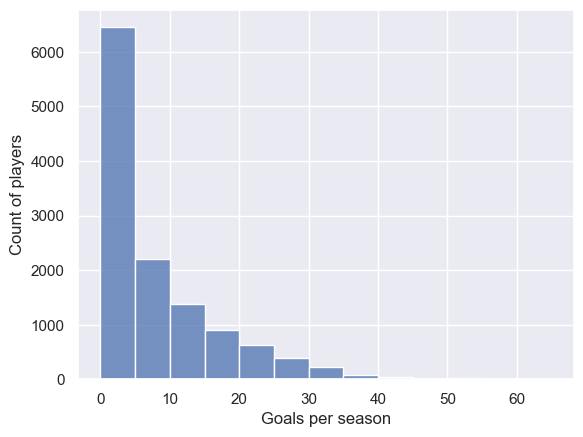

In [91]:
g = sns.histplot(data=df, x="G", binwidth=5)
plt.xlabel("Goals per season")
plt.ylabel("Count of players")

plt.show()

Here are the descriptive statistics:

In [92]:
df["G"].describe()

count    12328.000000
mean         7.484263
std          8.846936
min          0.000000
25%          1.000000
50%          4.000000
75%         11.000000
max         65.000000
Name: G, dtype: float64

In total there are 438 missing cells in the dataset, which is about 0.1% of all cells.
These are concentrated in two columns:
- FO_percent (faceoff win percentage)
- S_percent (shooting percentage)

In my opinion, this is most likely caused by the fact that the given players didn't take any faceoffs during the season (e.g. defensemen typically don't take faceoffs), or respectively didn't shoot at the goal (maybe the given player played just 1 game in whole season). Both cases will result in division by zero.

Missing values aren't denoted by any special strings (such as "None" or "Null"), there are just 2 consecutive commas in the given row.

## Exploratory analysis